# Wav2Vec2 - Release In The Wild - Retreival Augmented Framework for Deepfake Audio Detection

## Wav2Vec2 Model for Deepfake Audio Detection

### Summary of Key Processing Steps in Wav2Vec2

1. Directly processes raw audio using convolutional layers in the feature encoder.
2. Utilizes a Transformer to capture temporal relationships across the audio sequence.
3. Fine-tunes easily for classification tasks by adding a lightweight classification head.
4. Pre-trained on vast unlabeled audio data, enabling it to perform well with limited labeled data for classification.

## Training

In [4]:
import logging
from config import Config
from dataset import AudioDataset
import argparse
import os
from pipeline import DeepfakeDetectionPipeline
import torch

# ========================
# Main runner (same behavior; wandb toggle)
# ========================
"""
Run the complete audio deepfake detection pipeline with single-GPU optimizations.
"""
import argparse

# 1. Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

# 3. Disable problematic torchaudio backends
os.environ["TORCHAUDIO_USE_SOX"] = "0"
os.environ["TORCHAUDIO_USE_BACKEND_DISPATCHER"] = "1"

# 4. Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.set_device(device)

# 5. Create configuration
config = Config()
config.device = device

config.train_split = 0.8
mode = "train"
audio_path = None
config.feature_extractor_type = "wav2vec2"
pipeline_check = False

if pipeline_check:
  config.data_fraction = 0.01
  config.num_epochs = 2
  # 5a. Wandb toggle
  use_wandb = False  # set False to disable W&B
else:
  config.data_fraction = 1.0
  config.num_epochs = 10
  # 5a. Wandb toggle
  use_wandb = True  # set False to disable W&B


config.use_wandb = use_wandb

# 6. DataLoader settings
config.num_workers = max(1, torch.cuda.device_count() * 2)
config.train_batch_size = getattr(config, "train_batch_size", 256)
config.eval_batch_size = getattr(config, "eval_batch_size", 256)
config.db_batch_size = getattr(config, "db_batch_size", 64)
config.top_k = getattr(config, "top_k", 5)
config.use_batch_norm = False
config.use_layer_norm = True


# 7. Initialize pipeline
pipeline = DeepfakeDetectionPipeline(config)

if mode == "train":
    train_dataset = AudioDataset(config, is_train=True, split_data=True)
    val_dataset   = AudioDataset(config, is_train=False, split_data=True)
    pipeline.print_split_stats(train_dataset, "Train")
    pipeline.print_split_stats(val_dataset,   "Val")
    pipeline.train(train_dataset, val_dataset)

elif mode == "evaluate":
    config.use_wandb = False
    pipeline.load_models("final_model")
    pipeline.vector_db.load()

    test_dataset = AudioDataset(config, is_train=False, split_data=True)
    if hasattr(pipeline, "evaluate_with_metrics"):
        metrics = pipeline.evaluate_with_metrics(test_dataset)
        print("Evaluation metrics:")
        for key, value in metrics.items():
            print(f"{key}: {value}")
    else:
        loss, acc = pipeline.evaluate(test_dataset)
        print(f"Eval Loss: {loss:.4f}, Eval Acc: {acc:.4f}")

elif mode == "predict":
    if not audio_path:
        raise ValueError("Audio path must be provided for predict mode")
    pipeline.load_models("best_model")
    pipeline.vector_db.load()
    result = pipeline.predict(audio_path)
    logging.info(f"Prediction  : {result['prediction']}")
    logging.info(f"Probability(bona-fide) : {result['probability_bonafide']:.4f}")
    logging.info(f"Retrieved   : {result['retrieved_labels']}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Feature dimension set to: 768
Train set → total: 25423, bonafide: 9453 (37.18%), spoof: 15970 (62.82%)
Val set → total: 6356, bonafide: 2363 (37.18%), spoof: 3993 (62.82%)


Vector DB Build: 100%|██████████| 398/398 [11:44<00:00,  1.77s/it]
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: avinash-saxena (avinash-saxena-san-jose-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Evaluating: 100%|██████████| 25/25 [02:56<00:00,  7.07s/it]


Epoch 1: Train Loss: 0.8188, Train Acc: 0.6150, Val Loss: 0.7402, Val Acc:0.6403 | AUC: 0.7834, EER: 28.73% (thr=0.6040), Macro EER: 33.40%, min t-DCF: nan


Epoch 2/10:   1%|          | 1/100 [00:07<11:39,  7.07s/it]wandb: WARNING Tried to log to step 100 that is less than the current step 101. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 100 that is less than the current step 102. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Evaluating: 100%|██████████| 25/25 [02:57<00:00,  7.08s/it]


Epoch 2: Train Loss: 0.7146, Train Acc: 0.7053, Val Loss: 0.7012, Val Acc:0.7594 | AUC: 0.8254, EER: 25.23% (thr=-0.6899), Macro EER: 25.84%, min t-DCF: nan


Evaluating: 100%|██████████| 25/25 [02:44<00:00,  6.60s/it]


Epoch 3: Train Loss: 0.6553, Train Acc: 0.7462, Val Loss: 0.6449, Val Acc:0.7192 | AUC: 0.8565, EER: 22.69% (thr=0.9512), Macro EER: 24.54%, min t-DCF: nan


Epoch 4/10:   1%|          | 1/100 [00:06<11:29,  6.97s/it]wandb: WARNING Tried to log to step 300 that is less than the current step 301. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 300 that is less than the current step 302. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Evaluating: 100%|██████████| 25/25 [02:51<00:00,  6.85s/it]


Epoch 4: Train Loss: 0.6192, Train Acc: 0.7656, Val Loss: 0.5856, Val Acc:0.7588 | AUC: 0.8761, EER: 20.56% (thr=0.8110), Macro EER: 23.45%, min t-DCF: nan


Evaluating: 100%|██████████| 25/25 [02:45<00:00,  6.62s/it]


Epoch 5: Train Loss: 0.5915, Train Acc: 0.7796, Val Loss: 0.5450, Val Acc:0.7920 | AUC: 0.8853, EER: 20.39% (thr=0.0918), Macro EER: 20.95%, min t-DCF: nan


Evaluating: 100%|██████████| 25/25 [02:45<00:00,  6.62s/it]


Epoch 6: Train Loss: 0.5660, Train Acc: 0.7970, Val Loss: 0.7073, Val Acc:0.7070 | AUC: 0.8759, EER: 21.29% (thr=1.7217), Macro EER: 20.90%, min t-DCF: nan


Epoch 7/10:   2%|▏         | 2/100 [00:13<11:03,  6.77s/it]wandb: WARNING Tried to log to step 600 that is less than the current step 602. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 601 that is less than the current step 602. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Evaluating: 100%|██████████| 25/25 [02:44<00:00,  6.60s/it]


Epoch 7: Train Loss: 0.6108, Train Acc: 0.7727, Val Loss: 0.5189, Val Acc:0.8200 | AUC: 0.9010, EER: 18.24% (thr=-0.1290), Macro EER: 18.81%, min t-DCF: nan


Epoch 8/10:   1%|          | 1/100 [00:06<11:15,  6.82s/it]wandb: WARNING Tried to log to step 700 that is less than the current step 701. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 700 that is less than the current step 702. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Evaluating: 100%|██████████| 25/25 [02:44<00:00,  6.59s/it]


Epoch 8: Train Loss: 0.5372, Train Acc: 0.8062, Val Loss: 0.7850, Val Acc:0.6205 | AUC: 0.8984, EER: 18.80% (thr=1.9082), Macro EER: 19.10%, min t-DCF: nan


Evaluating: 100%|██████████| 25/25 [02:45<00:00,  6.60s/it]


Epoch 9: Train Loss: 0.5247, Train Acc: 0.8124, Val Loss: 0.7980, Val Acc:0.6542 | AUC: 0.8896, EER: 19.85% (thr=2.1484), Macro EER: 18.95%, min t-DCF: nan


Epoch 10/10:   1%|          | 1/100 [00:07<11:34,  7.02s/it]wandb: WARNING Tried to log to step 900 that is less than the current step 901. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 900 that is less than the current step 902. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Evaluating: 100%|██████████| 25/25 [02:43<00:00,  6.56s/it]


Epoch 10: Train Loss: 0.5169, Train Acc: 0.8173, Val Loss: 0.4741, Val Acc:0.8293 | AUC: 0.9167, EER: 16.72% (thr=0.1669), Macro EER: 16.01%, min t-DCF: nan


curves/auc,▁▃▅▆▆▆▇▇▇█
grad_norm/detection,▁▂▂▂▁▂▄▂▁▂▁▂▄▄▁▂▂▄▂▄▄▄▂▃▄█▃▂▂▁▅▄▆▁▁▂▂▁▁▃
grad_norm/fuse,▁▁▂▁▁▂▁▁▁▂▁▂▁▁▁▂▂▂▂▃▂▁▄▂▅▄▅▂▂▁▅▄▂▂▂▄▂█▅▇
grad_norm/projection,▂▁▁▁▁▂▃▁▂▁▂▁▁▃▁▂▂▃▂▁▂▂▂▃▂▁▃█▂▂▃▃▂█▅▂▂▃▄▂
lr/detection,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/fuse,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/projection,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_loss,█▆▆▆▅▅▅▄▄▃▃▃▃▃▂▃▂▂▃▃▃▃▇▂▃▂▂▁▃▂▆▂▂▂▁▂▁▃▃▄
train/nnz_neighbor_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
curves/auc,0.9167
grad_norm/detection,1.29739


## Loss and Accuracy Curves

In [5]:
pipeline.plot_training_curves()

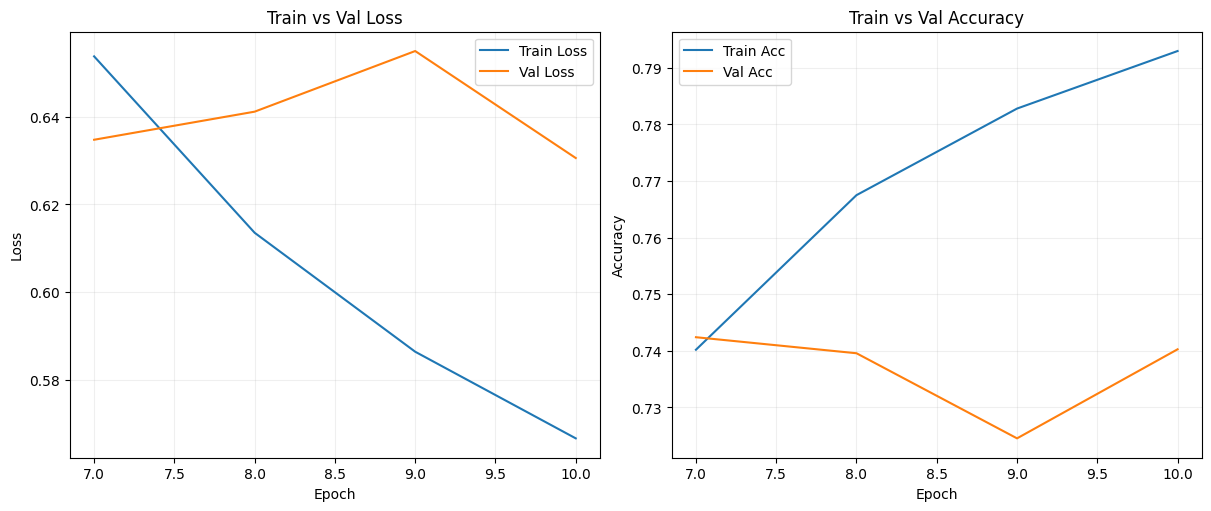

In [13]:
pipeline.show_curves_inline(smooth=7)

## Sample Predictions

### Spoof Prediction

In [15]:
import pandas as pd
file_name = "10136.wav"
audio_path = "/content/release_in_the_wild/"+file_name

df = pd.read_csv("/content/release_in_the_wild/meta.csv")
expected = df[df["file"]==file_name]


# 12. Single-file prediction on GPU
result = pipeline.predict(audio_path)

filtered_df = df[df["file"].isin(result['retrieved_files'])]


print(f"Prediction  : {result['prediction']}, Expected: {expected['label'].values[0]}, Speaker: {expected['speaker'].values[0]}")
print(f"Probability Spoof: {result['probability_spoof']:.4f}")
print("Similar Audio Files retrieved")
print(filtered_df)

Prediction  : spoof, Expected: spoof, Speaker: Alec Guinness
Probability Spoof: 0.9414
Similar Audio Files retrieved
            file                speaker  label
8551    8551.wav  Arnold Schwarzenegger  spoof
15187  15187.wav          Alec Guinness  spoof
21971  21971.wav               Ayn Rand  spoof
25803  25803.wav               Ayn Rand  spoof
29585  29585.wav          Alec Guinness  spoof


### Bonafide Prediction

In [16]:
file_name = "10135.wav"
audio_path = "/content/release_in_the_wild/"+file_name

df = pd.read_csv("/content/release_in_the_wild/meta.csv")
expected = df[df["file"]==file_name]


# 12. Single-file prediction on GPU
result = pipeline.predict(audio_path)

filtered_df = df[df["file"].isin(result['retrieved_files'])]


print(f"Prediction  : {result['prediction']}, Expected: {expected['label'].values[0]}, Speaker: {expected['speaker'].values[0]}")
print(f"Probability Spoof: {result['probability_spoof']:.4f}")
print("Similar Audio Files retrieved")
print(filtered_df)

Prediction  : bona-fide, Expected: bona-fide, Speaker: Barack Obama
Probability Spoof: 0.1082
Similar Audio Files retrieved
            file       speaker      label
3019    3019.wav  Barack Obama  bona-fide
5376    5376.wav  Barack Obama  bona-fide
7594    7594.wav  Barack Obama  bona-fide
7666    7666.wav  Barack Obama  bona-fide
21007  21007.wav  Barack Obama  bona-fide
